In [97]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from matplotlib import pyplot as plt

In [49]:
data = pd.read_csv("AOD_series.csv")
data.head()

,Wk_1_2014,Wk_2_2014,Wk_3_2014,Wk_4_2014,Wk_5_2014,Wk_6_2014,Wk_7_2014,Wk_8_2014,Wk_9_2014,Wk_10_2014,...,Wk_44_2018,Wk_45_2018,Wk_46_2018,Wk_47_2018,Wk_48_2018,Wk_49_2018,Wk_50_2018,Wk_51_2018,Wk_52_2018,Wk_53_2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# remove rows with only NAs
data.dropna(axis=0, how="all", inplace=True)
data.head()

,Wk_1_2014,Wk_2_2014,Wk_3_2014,Wk_4_2014,Wk_5_2014,Wk_6_2014,Wk_7_2014,Wk_8_2014,Wk_9_2014,Wk_10_2014,...,Wk_44_2018,Wk_45_2018,Wk_46_2018,Wk_47_2018,Wk_48_2018,Wk_49_2018,Wk_50_2018,Wk_51_2018,Wk_52_2018,Wk_53_2018
422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.205000,NaN,0.184122,NaN,0.406391,0.136056,0.204676,NaN
423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.174868,NaN,0.405219,0.117110,0.197330,NaN
424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.090549,NaN,0.169360,NaN,0.396316,0.108810,0.174159,NaN
425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.100307,NaN,0.161345,NaN,0.371792,0.105233,0.143394,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.108512,NaN,0.152003,NaN,0.310051,0.107123,0.125354,NaN


There are 2 options for LSTM data: using a time series of each individual cell's data, or using a time series of rasters. By row, the data is already formatted for the former.  
As each column represents one raster time point, for the latter, we split the columns into rolling windows.

### Predicting whole rasters

In [89]:
window_length = 10
windows = np.empty((data.shape[1] - window_length, window_length, data.shape[0]))
targets = np.empty((windows.shape[0], 1, data.shape[0]))

In [90]:
for i in tqdm(range(data.shape[1] - window_length)):
    # missing values filled with -1 for now
    windows[i, :, :] = np.array(data.iloc[:, i:(i + window_length)].fillna(-1)).transpose()
    targets[i, :, :] = np.array(data.iloc[:, i + window_length].fillna(-1)).transpose().reshape(1, targets.shape[2])

100%|██████████| 254/254 [00:00<00:00, 281.10it/s]


In [91]:
# check whether targets assigned correctly
all(windows[10, 0, :] == targets[0, 0, :])

True

In [224]:
# check whether window data assigned correctly
all(windows[window_length, 0, :] == np.array(data.iloc[:, window_length].fillna(-1)))

True

In [93]:
windows.shape # number of windows x window length x number of data points

(254, 10, 30310)

In [94]:
targets.shape

(254, 1, 30310)

In [95]:
model = Sequential()
model.add(LSTM(window_length, input_shape=(window_length, windows.shape[2])))
model.add(Dense(targets.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [96]:
model.fit(windows, targets, epochs=1, batch_size=1)

254/254 [==============================] - 8s 26ms/step - loss: 0.3406


In [125]:
test_data = np.array(data.iloc[:, window_length].fillna(-1))
test_pred = model.predict(windows[0, :, :].reshape(1, window_length, 30310)).reshape(30310)

In [213]:
# add back empty observations
padded_data = np.full((59000), np.nan)
padded_pred = np.full((59000), np.nan)
padded_data[data.index] = np.where(test_data == -1, np.nan, test_data)
padded_pred[data.index] = test_pred
padded_data = padded_data.reshape(295, 200)
padded_pred = padded_pred.reshape(295, 200)
# padded_data = np.where(padded_data == -1, np.nan, padded_data)
# padded_pred = np.where(padded_pred == -1, np.nan, padded_pred)

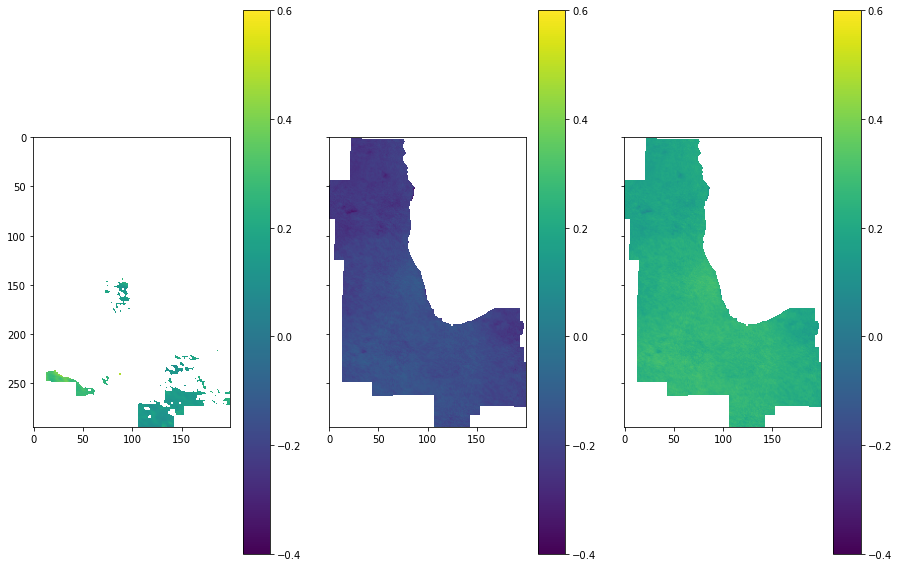

In [223]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -0.4, 'vmax': 0.6}
im1 = ax1.imshow(padded_data, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(padded_pred - padded_pred[~np.isnan(padded_pred)].min(), **opts) # prediction shifted st min is zero
plt.colorbar(im3, ax=ax3)
plt.show()

In [292]:
pd.concat([pd.DataFrame(test_data).describe(), pd.DataFrame(test_pred).describe()], axis=1)

,0,0
count,30310.000000,30310.000000
mean,-0.875477,-0.185916
std,0.363190,0.035619
min,-1.000000,-0.415555
25%,-1.000000,-0.213583
50%,-1.000000,-0.180272
75%,-1.000000,-0.157915
max,0.519000,-0.086403


### Predicting individual cells  
Generating individual cell predictions is much the same, but on a smaller scale. Instead of using few, large observations, we use many small observations, which may be easier for the model to fit.

In [266]:
def flattenArray(input):
    """
    Reshapes raster time series into time series of individual cells.
    """
    reshape = np.empty((input.shape[0] * input.shape[2], input.shape[1], 1))
    for i in tqdm(range(input.shape[0])):
        for j in range(input.shape[2]):
            reshape[i * input.shape[2] + j, :, :] = input[i, :, j].reshape(input.shape[1], 1)
    return reshape

In [265]:
windows_flat = flattenArray(windows)
targets_flat = flattenArray(targets)

100%|██████████| 254/254 [00:09<00:00, 25.54it/s]


In [300]:
model_flat = Sequential()
model_flat.add(LSTM(window_length, input_shape=(window_length, 1)))
model_flat.add(Dense(1))
model_flat.compile(loss='mean_squared_error', optimizer='adam')

In [301]:
model_flat.fit(windows_flat, targets_flat, epochs=1, batch_size=512)

15037/15037 [==============================] - 50s 3ms/step - loss: 0.2761


In [302]:
test_pred_flat = model_flat.predict(windows_flat[:30310, :, :]).reshape(30310)

In [303]:
padded_pred_flat = np.full((59000), np.nan)
padded_pred_flat[data.index] = test_pred_flat
padded_pred_flat = padded_pred_flat.reshape(295, 200)

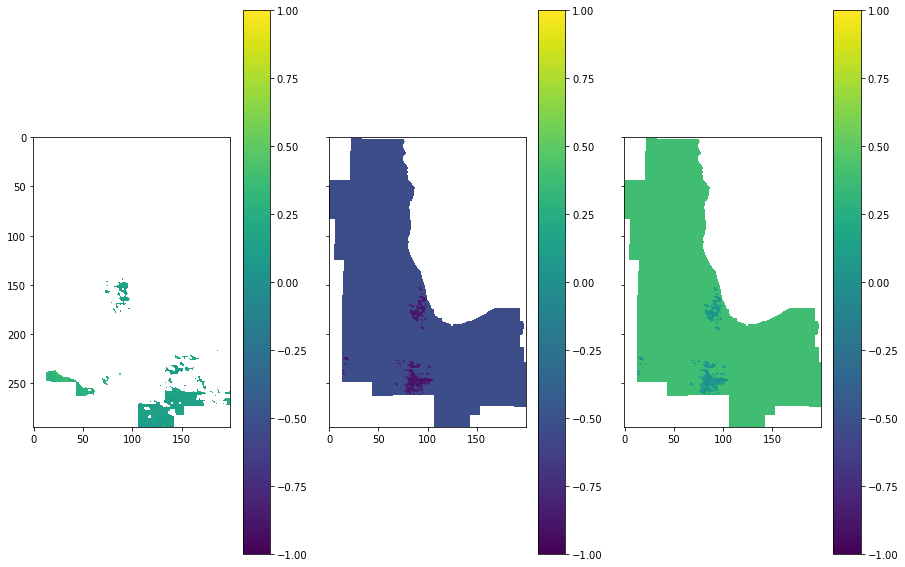

In [304]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred_flat, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(padded_pred_flat - padded_pred_flat[~np.isnan(padded_pred_flat)].min(), **opts) # prediction shifted st min is zero
plt.colorbar(im3, ax=ax3)
plt.show()

In [305]:
pd.concat([pd.DataFrame(test_data).describe(), pd.DataFrame(test_pred_flat).describe()], axis=1)

,0,0
count,30310.000000,30310.000000
mean,-0.875477,-0.535587
std,0.363190,0.053595
min,-1.000000,-0.911473
25%,-1.000000,-0.527345
50%,-1.000000,-0.527345
75%,-1.000000,-0.527345
max,0.519000,-0.168060
